In [1]:
import numpy as np
import pandas as pd
import PyMca5 as pymca
from rsciio.phenom import file_reader
from scipy.ndimage import zoom
import hyperspy.api as hs
import matplotlib.pyplot as plt
from scipy.ndimage import zoom
import pdfplumber
from scipy.signal import find_peaks
from scipy.signal import savgol_filter

In [2]:
#Reading test.elid
filepath = "/home/sakshis/Matraca/Matraca/C1_10-11-2023/C1_10-11-2023.elid"
#Reading X-Ray data
pdf_path = "Table_1-2.pdf"

In [3]:
#Extracting data and putting it into a dataframe
datasets = file_reader(filepath)
df = pd.DataFrame(datasets)

In [4]:
df.head()

,data,axes,metadata,original_metadata,mapping
0,"[[97, 99, 102, 105, 105, 105, 105, 98, 100, 10...","[{'index_in_array': 0, 'name': 'y', 'offset': ...",{'General': {'original_filename': 'C1_10-11-20...,"{'databarHeight': '0', 'databarFields': '4091'...",{'acquisition.scan.detectors.EDS.detector_azim...
1,"[[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0...","[{'index_in_array': 0, 'name': 'y', 'offset': ...",{'General': {'original_filename': 'C1_10-11-20...,"{'databarHeight': '0', 'databarFields': '4091'...",{'acquisition.scan.detectors.EDS.detector_azim...
2,"[[108, 102, 97, 99, 108, 102, 102, 105, 106, 1...","[{'index_in_array': 0, 'name': 'y', 'offset': ...",{'General': {'original_filename': 'C1_10-11-20...,"{'databarHeight': '0', 'databarFields': '4091'...",{'acquisition.scan.detectors.EDS.detector_azim...
3,"[[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0...","[{'index_in_array': 0, 'name': 'y', 'offset': ...",{'General': {'original_filename': 'C1_10-11-20...,"{'databarHeight': '0', 'databarFields': '4091'...",{'acquisition.scan.detectors.EDS.detector_azim...


### What is a sum peak?
- The result to two or more X-ray photons being incident on the EDS detection at virtually the exact same time.
- If two or more X-ray photons arrive at the detector within this minimum time, the photons will not be discriminated as separate X-ray photons but as a single photon.
- The energy recorded is the sum of the coincident X-ray photons. These X-ray photons may or may not be of the same energy.
- Because sum peaks are a result of multiple X-ray photons being incident on the detector in very small amounts of time, it follows that at a
given fixed pulse processing time constant, higher count rates will increase the likelihood of sum peaks.

In [5]:
#Extracting the SEM image energy values
sem_image = df['data'][0] #600*960 image
eds_data =  df['data'][1] #actual spectra values 

In [6]:
scale_factors = (
            sem_image.shape[0] / eds_data.shape[0], 
            sem_image.shape[1] / eds_data.shape[1]
        )

In [7]:
rescaled_eds_map = np.zeros((600,960,2048), dtype=np.uint64)
for i in range(2048):
    rescaled_eds_map[:,:,i] = zoom(eds_data[:,:,i], scale_factors, order=1)

In [8]:
#Channel number
scale_factor = df['axes'][1][2]['scale']*100

In [9]:
energy_range = np.arange(2048) * scale_factor

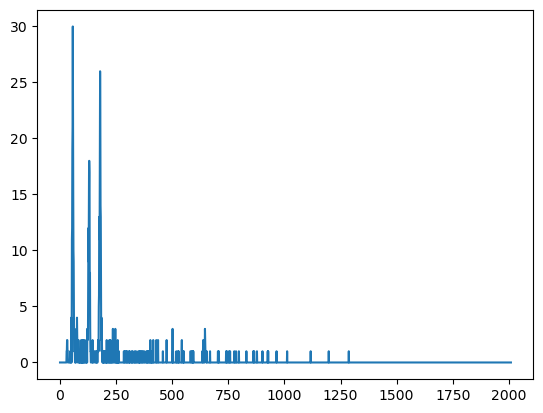

In [10]:
#For reference using pixel 50,40. Plotting it's reactions when exposed to various energies
plt.plot(energy_range,rescaled_eds_map[100,40,:])

In [11]:
cur_pixel = rescaled_eds_map[100,40,:]

In [12]:
peaks,_ = find_peaks(cur_pixel)

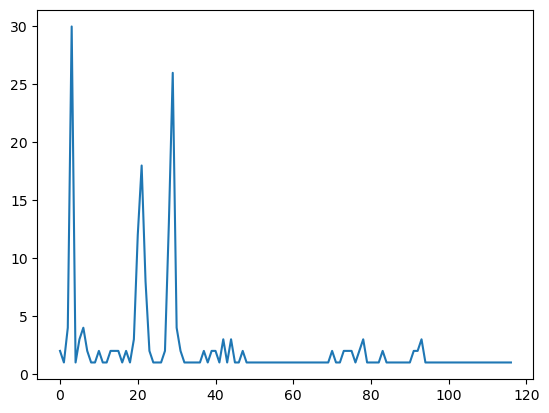

In [13]:
plt.plot(cur_pixel[peaks])

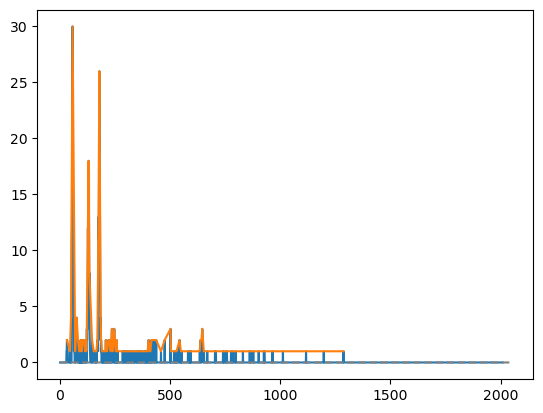

In [14]:
plt.plot(energy_range,cur_pixel)
plt.plot(energy_range[peaks],cur_pixel[peaks])
plt.plot(np.zeros_like(energy_range), "--", color="gray")
plt.show()

In [15]:
sum_peaks = []
sum_peak_ids = {}
for idx_i in range(len(peaks)):
    for idx_j in range(idx_i,len(peaks)):
        i,j = peaks[idx_i],peaks[idx_j]
        
        sum_energy = energy_range[i]+energy_range[j]
        possible_sum_peak = np.abs(energy_range - sum_energy).argmin()
        
        if possible_sum_peak in peaks:
            sum_peaks.append(possible_sum_peak)
            sum_peak_ids[possible_sum_peak] = (energy_range[i],energy_range[j])

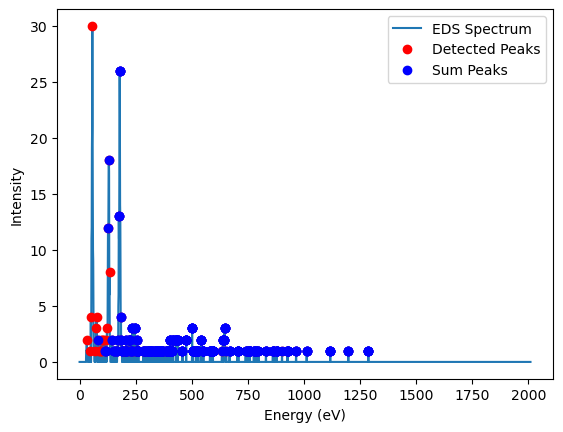

In [21]:
plt.plot(energy_range, cur_pixel, label="EDS Spectrum")
plt.plot(energy_range[peaks], cur_pixel[peaks], "ro", label="Detected Peaks")
plt.plot(energy_range[sum_peaks], cur_pixel[sum_peaks], "bo", label="Sum Peaks")
plt.xlabel("Energy (eV)")
plt.ylabel("Intensity")
plt.legend()
plt.show()

In [42]:
from sklearn.mixture import GaussianMixture

X = energy_range.reshape(-1,1)
Y = cur_pixel.reshape(-1, 1)

gmm = GaussianMixture(n_components=10, covariance_type='full', random_state=42)
gmm.fit(np.hstack([X, Y]))

means = gmm.means_[:, 0]         
weights = gmm.weights_           
covars = gmm.covariances_[:, 0, 0] 
stds = np.sqrt(gmm.covariances_[:, 0, 0]) 
amplitudes = weights * np.max(cur_pixel)

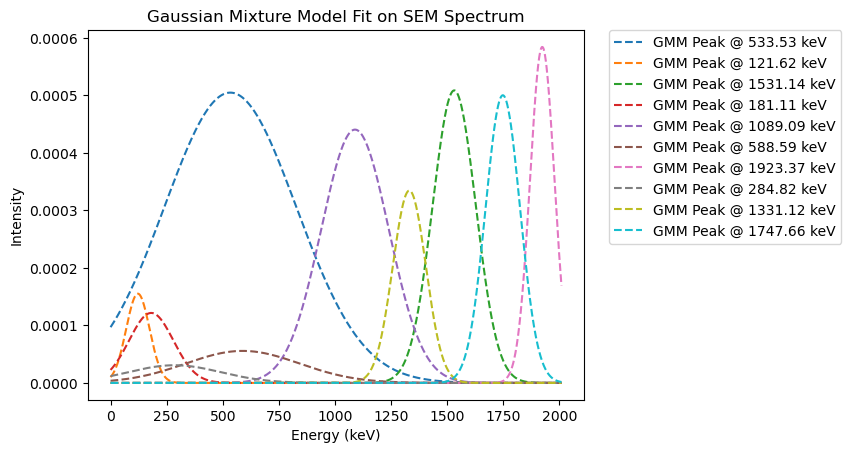

In [35]:
# Plot fitted Gaussians
for mean, std, weight in zip(means, np.sqrt(covars), weights):
    peak = weight * norm.pdf(energy_range, mean, std)
    plt.plot(energy_range, peak, '--', label=f'GMM Peak @ {mean:.2f} keV')

plt.legend(
    bbox_to_anchor=(1.05, 1),  
    loc='upper left',
    borderaxespad=0.
)
plt.xlabel("Energy (keV)")
plt.ylabel("Intensity")
plt.title("Gaussian Mixture Model Fit on SEM Spectrum")
plt.show()

In [44]:
indices = np.searchsorted(energy_range, means)

# Ensure indices are in valid range
indices = np.clip(indices, 0, len(cur_pixel) - 1)

actual_counts = cur_pixel[indices]

gmm_peak_table = pd.DataFrame({
     "Peak Energy (keV)": means,
    "Actual Counts": actual_counts.astype(int),
    "Std Dev (keV)": stds
}).sort_values(by="Peak Energy (keV)")

print(gmm_peak_table)

   Peak Energy (keV)  Actual Counts  Std Dev (keV)
1         121.621035              3      51.996176
3         181.112880             13      98.736113
7         284.824034              0     206.470824
0         533.533098              0     293.670603
5         588.587222              0     253.069425
4        1089.092181              0     150.599451
8        1331.124657              0      73.809535
2        1531.136706              0      96.175932
9        1747.662675              0      77.023203
6        1923.369407              0      54.391120


In [49]:
###Estimate the number of components for a GMM
def estimate_num_peaks(x, y, max_components=10):
    X = y.reshape(-1, 1)
    lowest_bic = np.inf
    best_gmm = None
    bics = []

    for n in range(1, max_components + 1):
        gmm = GaussianMixture(n_components=n)
        gmm.fit(X)
        bic = gmm.bic(X)
        bics.append(bic)
        if bic < lowest_bic:
            lowest_bic = bic
            best_gmm = gmm

    # Plot BIC values
    plt.figure(figsize=(6,4))
    plt.plot(range(1, max_components + 1), bics, marker='o')
    plt.title("BIC vs. Number of GMM Components")
    plt.xlabel("Number of Components")
    plt.ylabel("BIC")
    plt.show()

    return best_gmm, np.argmin(bics) + 1  

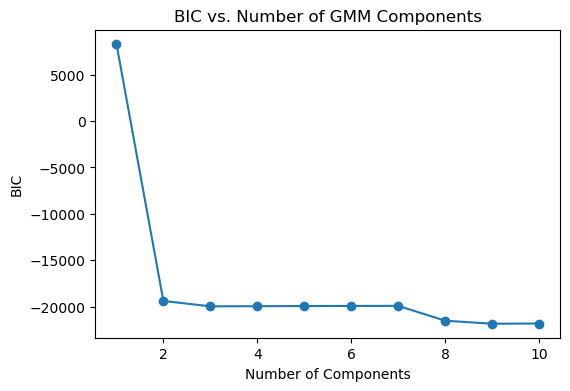

Estimated number of peaks: 9


In [50]:
best_model, n_peaks = estimate_num_peaks(energy_range, cur_pixel)
print(f"Estimated number of peaks: {n_peaks}")

In [54]:
gmm = GaussianMixture(n_components=4, random_state=42)
gmm.fit(X)

means = gmm.means_.flatten()

indices = np.searchsorted(energy_range, means)
indices = np.clip(indices, 0, len(cur_pixel) - 1)
actual_counts = cur_pixel[indices]

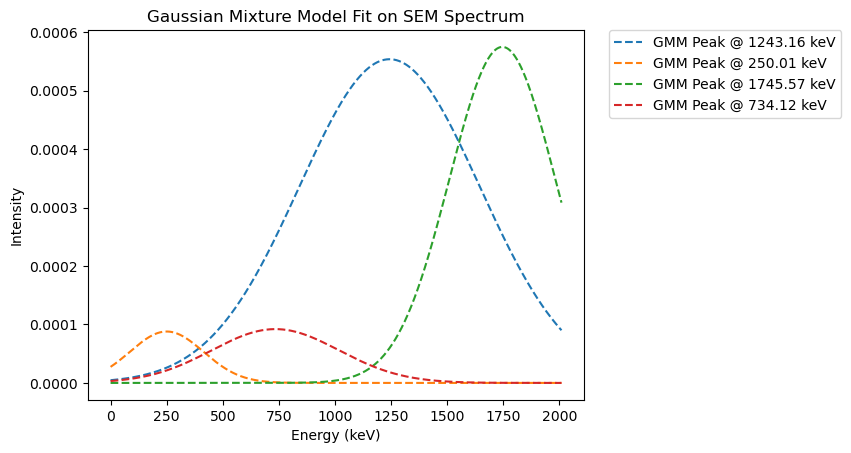

In [60]:
for mean, std, weight in zip(means, np.sqrt(covars), weights):
    peak = weight * norm.pdf(energy_range, mean, std)
    plt.plot(energy_range, peak, '--', label=f'GMM Peak @ {mean:.2f} keV')

plt.legend(
    bbox_to_anchor=(1.05, 1),  
    loc='upper left',
    borderaxespad=0.
)
plt.xlabel("Energy (keV)")
plt.ylabel("Intensity")
plt.title("Gaussian Mixture Model Fit on SEM Spectrum")
plt.show()

In [58]:
# Function to find the nearest index in energy_range for each GMM mean
def find_nearest_indices(energy_array, target_values):
    return [np.abs(energy_array - val).argmin() for val in target_values]

indices = find_nearest_indices(energy_range, means)

actual_counts = cur_pixel[indices]

In [59]:
df = pd.DataFrame({
    "Peak Energy (keV)": means,
    "Actual Counts": actual_counts.astype(int)
}).sort_values(by="Peak Energy (keV)")

print(df)

   Peak Energy (keV)  Actual Counts
1         250.009793              0
3         734.124119              0
0        1243.160200              0
2        1745.567827              0


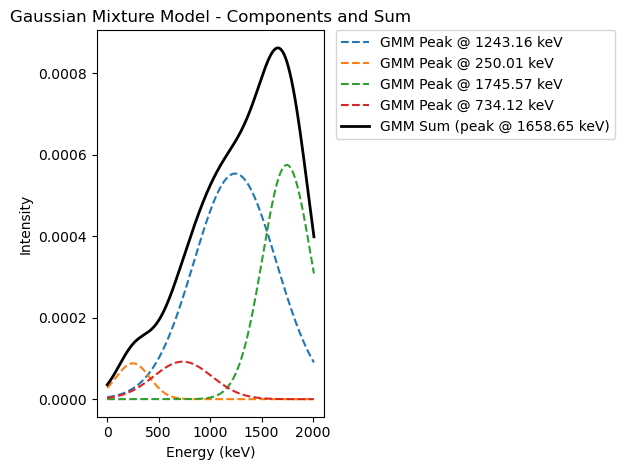

In [64]:
reconstructed_signal = np.zeros_like(energy_range)
for mean, std, weight in zip(means, np.sqrt(covars), weights):
    peak = weight * norm.pdf(energy_range, mean, std)
    reconstructed_signal += peak
    plt.plot(energy_range, peak, '--', label=f'GMM Peak @ {mean:.2f} keV')

peak_index = np.argmax(reconstructed_signal)
peak_energy = energy_range[peak_index]

plt.plot(energy_range, reconstructed_signal, color='black', linewidth=2,
         label=f'GMM Sum (peak @ {peak_energy:.2f} keV)')

plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
plt.xlabel("Energy (keV)")
plt.ylabel("Intensity")
plt.title("Gaussian Mixture Model - Components and Sum")
plt.tight_layout()
plt.show()

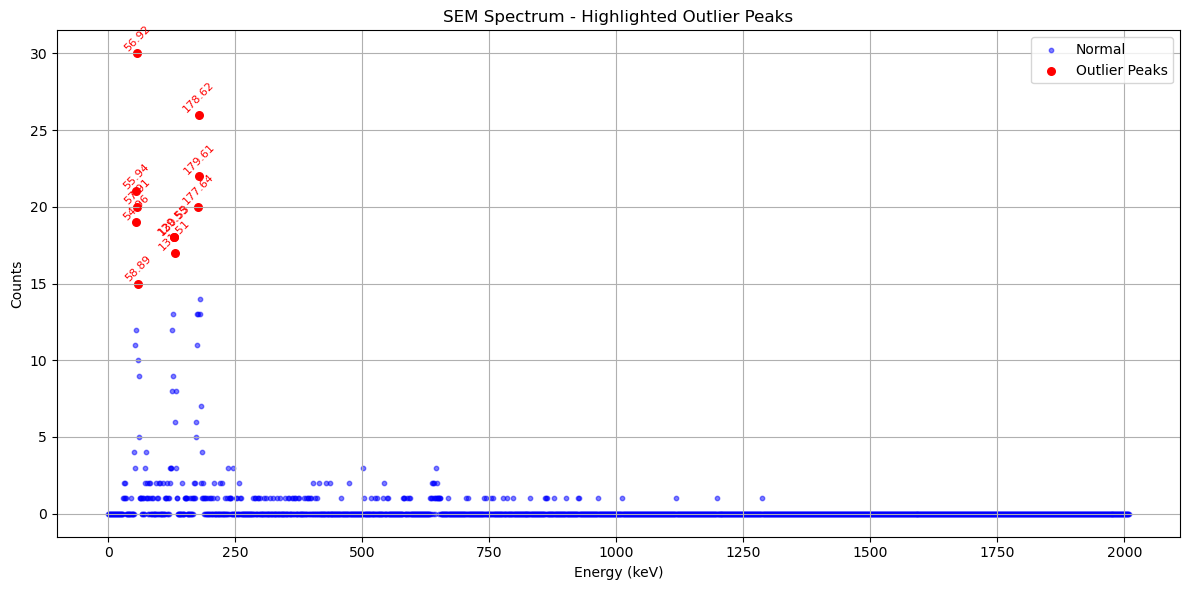

In [65]:
threshold = np.percentile(cur_pixel, 99.5)  # Top 0.5% as outliers
outlier_mask = cur_pixel > threshold

plt.figure(figsize=(12, 6))
plt.scatter(energy_range, cur_pixel, s=10, alpha=0.5, label="Normal", color="blue")
plt.scatter(energy_range[outlier_mask], cur_pixel[outlier_mask], s=30, color="red", label="Outlier Peaks")

for x, y in zip(energy_range[outlier_mask], cur_pixel[outlier_mask]):
    plt.text(x, y, f"{x:.2f}", fontsize=8, color='red', ha='center', va='bottom', rotation=45)

# --- Plot settings ---
plt.xlabel("Energy (keV)")
plt.ylabel("Counts")
plt.title("SEM Spectrum - Highlighted Outlier Peaks")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [66]:
threshold = np.percentile(cur_pixel, 99.5)
outlier_mask = cur_pixel > threshold

# Step 2: Extract the outlier energies and their counts
outlier_energies = energy_range[outlier_mask]
outlier_counts = cur_pixel[outlier_mask]

# Step 3: Create and display the DataFrame
outlier_df = pd.DataFrame({
    "Energy (keV)": outlier_energies,
    "Counts": outlier_counts.astype(int)
}).sort_values(by="Energy (keV)")

# Print the table
print(outlier_df.to_string(index=False))

 Energy (keV)  Counts
    54.961101      19
    55.942549      21
    56.923998      30
    57.905446      20
    58.886894      15
   129.551167      18
   130.532615      18
   131.514063      17
   177.642130      20
   178.623579      26
   179.605027      22


In [67]:
weighted_energy = np.repeat(energy_range, cur_pixel.astype(int))

# Fit GMM only on energy, but weighted by real SEM counts
weighted_energy = weighted_energy.reshape(-1, 1)
gmm = GaussianMixture(n_components=5, random_state=42)
gmm.fit(weighted_energy)

# Now extract peak positions
gmm_peaks = gmm.means_.flatten()